In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import tensorflow as tf

In [95]:
#-
data: pd.DataFrame = pd.read_csv("Cars.csv")

In [96]:
#-
data.drop(columns=['Unnamed: 0'], inplace=True)

data.head(), data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company Names     1206 non-null   object 
 1   Cars Names        1206 non-null   object 
 2   Engines           1206 non-null   object 
 3   HorsePower        1206 non-null   float64
 4   Fuel Types        1206 non-null   object 
 5   Seats             1206 non-null   int64  
 6   Torque            1206 non-null   float64
 7   Price             1206 non-null   float64
 8   Speed             1206 non-null   float64
 9   Acceleration      1206 non-null   float64
 10  Battery Capacity  1204 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 103.8+ KB


(  Company Names     Cars Names      Engines  HorsePower      Fuel Types  \
 0       FERRARI  SF90 STRADALE           V8       963.0  plug-in hybrid   
 1   ROLLS ROYCE        PHANTOM          V12       563.0          petrol   
 2          Ford            KA+  1.2L Petrol        70.0          petrol   
 3      MERCEDES        GT 63 S           V8       630.0          petrol   
 4          AUDI     AUDI R8 Gt          V10       602.0          petrol   
 
    Seats  Torque      Price  Speed  Acceleration  Battery Capacity  
 0      2   800.0  1100000.0  340.0           2.5            3990.0  
 1      5   900.0   460000.0  250.0           5.3            6749.0  
 2      5   100.0    13500.0  165.0          10.5            1200.0  
 3      4   900.0   161000.0  250.0           3.2            3982.0  
 4      2   560.0   253290.0  320.0           3.6            5204.0  ,
 None,
 (1206, 11))

In [97]:
#-
data[data.duplicated()]

,Company Names,Cars Names,Engines,HorsePower,Fuel Types,Seats,Torque,Price,Speed,Acceleration,Battery Capacity
1011,Ford,KA+,1.2L Petrol,70.0,petrol,5,100.0,13500.0,165.0,10.5,1200.0


In [98]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [99]:
#-
len(data["Cars Names"].unique()) 
#Il y a 1193 Cars Names différentes, sur 1206 voitures uniques.
#ça ne sert à rien de garder cette colonne, elle ne nous apportera aucune information pour la prédiction.

1193

In [100]:
data.drop(columns=["Cars Names"], inplace=True)
data.head()

,Company Names,Engines,HorsePower,Fuel Types,Seats,Torque,Price,Speed,Acceleration,Battery Capacity
0,FERRARI,V8,963.0,plug-in hybrid,2,800.0,1100000.0,340.0,2.5,3990.0
1,ROLLS ROYCE,V12,563.0,petrol,5,900.0,460000.0,250.0,5.3,6749.0
2,Ford,1.2L Petrol,70.0,petrol,5,100.0,13500.0,165.0,10.5,1200.0
3,MERCEDES,V8,630.0,petrol,4,900.0,161000.0,250.0,3.2,3982.0
4,AUDI,V10,602.0,petrol,2,560.0,253290.0,320.0,3.6,5204.0


In [101]:
#-
data.describe()

,HorsePower,Seats,Torque,Price,Speed,Acceleration,Battery Capacity
count,1205.000000,1205.000000,1205.000000,1.205000e+03,1205.000000,1205.000000,1203.000000
mean,299.363485,4.840664,426.365145,1.389630e+05,217.008299,7.559419,2746.981712
std,210.317113,1.415801,291.055105,7.145107e+05,52.722617,3.310517,1932.901974
min,1.000000,1.000000,1.000000,4.000000e+03,80.000000,1.900000,1.000000
25%,150.000000,4.000000,250.000000,2.800000e+04,180.000000,5.200000,1500.000000
50%,250.000000,5.000000,366.000000,4.279500e+04,200.000000,7.100000,2000.000000
75%,400.000000,5.000000,560.000000,7.000000e+04,250.000000,9.500000,3564.000000
max,1850.000000,12.000000,3500.000000,1.800000e+07,500.000000,35.000000,16100.000000


On a des outliers (max 5 à 10 fois plus grands que les autres), on ne pourra pas entraîner un reseau de neurones dessus, il faudra probablement faire du log sur les données pour les ramener à une échelle plus raisonnable.

In [102]:
#-
company_names = pd.DataFrame(data["Company Names"].unique(), columns=["Company"])
company_names.sort_values(by="Company", inplace=True)
company_names

,Company
6,ASTON MARTIN
4,AUDI
34,Acura
7,BENTLEY
5,BMW
31,Bugatti
22,Cadillac
27,Chevrolet
0,FERRARI
2,Ford


On voit qu'il y a des valeurs avec et sans majuscules (Kia, KIA, etc.). Il faudra tout mettre en lower case, et enlever, s'il y a, les espaces avant et après les noms de marques.

In [103]:
#-
data["Company Names"] = data["Company Names"].apply(lambda x: x.strip().lower())
data["Company Names"].unique().shape

# On est passé de 37 valeurs uniques à 31.

(31,)

In [104]:
#-
cols = ["Engines", "Fuel Types"]

for col in cols:
    print(f"Nombre de valeurs uniques dans la colonne {col} avant nettoyage : {data[col].nunique()}")
    data[cols] = data[cols].apply(lambda x: x.str.strip().str.lower())
    print(f"Nombre de valeurs uniques dans la colonne {col} après nettoyage : {data[col].nunique()}")


Nombre de valeurs uniques dans la colonne Engines avant nettoyage : 350
Nombre de valeurs uniques dans la colonne Engines après nettoyage : 347
Nombre de valeurs uniques dans la colonne Fuel Types avant nettoyage : 9
Nombre de valeurs uniques dans la colonne Fuel Types après nettoyage : 9


In [105]:
#-
print(data["Fuel Types"].unique())
data["Fuel Types"].nunique()
# Il y a 9 fuel types différents

['plug-in hybrid' 'petrol' 'diesel' 'hybrid' 'electric' 'petrol & diesel'
 'hydrogen' 'cng' 'hybrid / plug-in']


9

In [106]:
#-
data["Fuel Types"].replace("plug-in hybrid", "hybrid", inplace=True)
data["Fuel Types"].replace("hybrid / plug-in", "hybrid", inplace=True)
data["Fuel Types"].unique()

C:\Users\thoma\AppData\Local\Temp\ipykernel_11400\1725509576.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Fuel Types"].replace("plug-in hybrid", "hybrid", inplace=True)
C:\Users\thoma\AppData\Local\Temp\ipykernel_11400\1725509576.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

array(['hybrid', 'petrol', 'diesel', 'electric', 'petrol & diesel',
       'hydrogen', 'cng'], dtype=object)

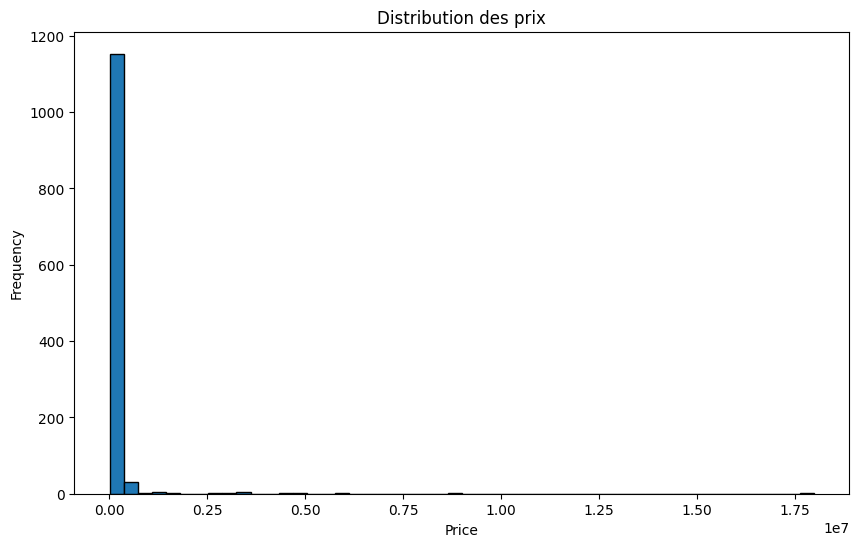

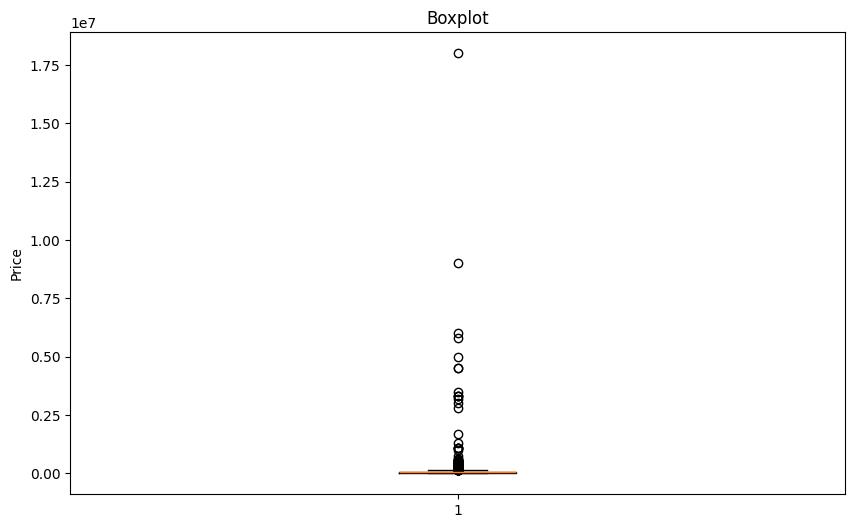

In [107]:
#-
plt.figure(figsize=(10, 6))
plt.hist(data["Price"], bins=50, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution des prix')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(data["Price"])
plt.ylabel('Price')
plt.title('Boxplot')
plt.show()

Non on ne peut pas conserver ces prix tels quels car il y a des outliers extrêmes.

In [108]:
#-
data["Price"] = np.log1p(data["Price"])

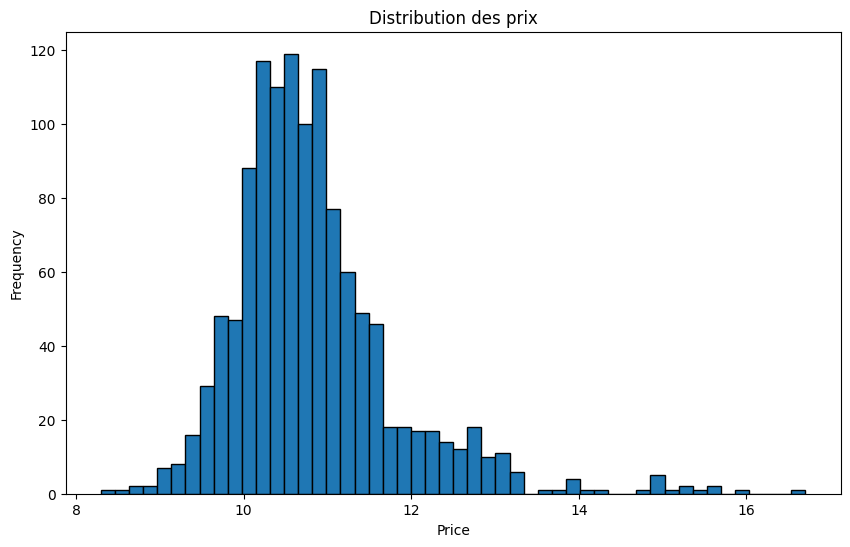

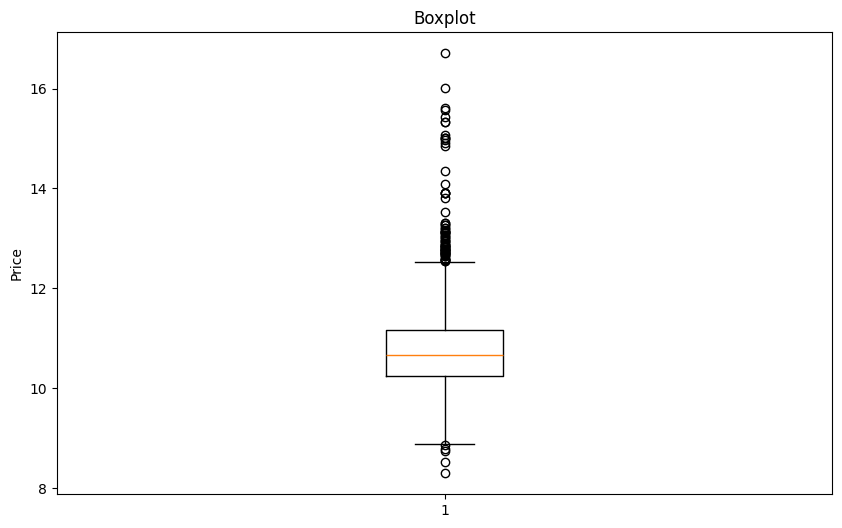

In [109]:
#-
plt.figure(figsize=(10, 6))
plt.hist(data["Price"], bins=50, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution des prix')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(data["Price"])
plt.ylabel('Price')
plt.title('Boxplot')
plt.show()

In [110]:
# ⚠️ CORRECTION CRITIQUE: Gérer les valeurs manquantes
print("=== Valeurs manquantes AVANT nettoyage ===")
print(data.isna().sum()[data.isna().sum() > 0])

# Remplir les NaN dans Battery Capacity par la médiane (plus robuste que la moyenne)
if 'Battery Capacity' in data.columns and data['Battery Capacity'].isna().sum() > 0:
    median_battery = data['Battery Capacity'].median()
    print(f"\nNaN dans Battery Capacity: {data['Battery Capacity'].isna().sum()}")
    print(f"Remplacement par la médiane: {median_battery}")
    data['Battery Capacity'].fillna(median_battery, inplace=True)

# Vérifier qu'il n'y a plus de NaN
print(f"\n=== Valeurs manquantes APRÈS nettoyage ===")
print(data.isna().sum().sum())


=== Valeurs manquantes AVANT nettoyage ===
Battery Capacity    2
dtype: int64

NaN dans Battery Capacity: 2
Remplacement par la médiane: 2000.0

=== Valeurs manquantes APRÈS nettoyage ===
0


C:\Users\thoma\AppData\Local\Temp\ipykernel_11400\3988368500.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Battery Capacity'].fillna(median_battery, inplace=True)


## 🛠️ Résumé des corrections appliquées

### Problèmes trouvés et résolus :

1. **Colonnes one-hot de type `bool`** → Ajout de `dtype=float` à `pd.get_dummies()` (cellule 23)
   - Pandas 2.0+ crée des bool par défaut → array numpy de type `object` → Keras ne peut pas calculer les gradients

2. **Normalisation des colonnes one-hot** → Définition explicite de `numeric_features` (cellule 24)
   - StandardScaler normalisait TOUT → transformait `[0, 1]` en `[-0.16, ...]`
   - Solution : scaler uniquement les 6 colonnes numériques d'origine

3. **2 NaN dans Battery Capacity** → Remplacement par la médiane (cellule ci-dessous)
   - Keras ne peut pas entraîner avec des NaN → modèle bloqué sur prédiction de la moyenne
   
**Voir le fichier `CORRECTIONS_APPLIQUEES.md` pour plus de détails**

In [111]:
#-
# Find values with single occurrence in object columns
single_occurrences = {}
for col in data.select_dtypes(include='object').columns:
    value_counts = data[col].value_counts()
    single_occurrence = value_counts[value_counts == 1]
    if len(single_occurrence) > 0:
        single_occurrences[col] = single_occurrence.index.tolist()
        print(f"\n{col} - Values with single occurrence ({len(single_occurrence)}):")
        print(single_occurrence)


Company Names - Values with single occurrence (1):
Company Names
bentley    1
Name: count, dtype: int64

Engines - Values with single occurrence (196):
Engines
1.8l rotary                     1
1.3l rotary                     1
2.6l wankel rotary engine       1
0.66l inline-3                  1
0.36l inline-2                  1
                               ..
3.0l inline-4                   1
1.4l,4-cylinder,inline-4(i4)    1
1.2l petrol                     1
hybrid                          1
2.5l hybrid / plug-in hybrid    1
Name: count, Length: 196, dtype: int64

Fuel Types - Values with single occurrence (1):
Fuel Types
cng    1
Name: count, dtype: int64


In [112]:
une_valeur_par_colonne = {col: values[0] for col, values in single_occurrences.items()}
une_valeur_par_colonne

{'Company Names': 'bentley', 'Engines': '1.8l rotary', 'Fuel Types': 'cng'}

In [113]:
#-
data = pd.get_dummies(data, columns=list(data.select_dtypes(include='object').columns), dtype=float)
data.head()

,HorsePower,Seats,Torque,Price,Speed,Acceleration,Battery Capacity,Company Names_acura,Company Names_aston martin,Company Names_audi,...,Engines_v8,Engines_v8 gasoline engine,Engines_v8 petrol,Fuel Types_cng,Fuel Types_diesel,Fuel Types_electric,Fuel Types_hybrid,Fuel Types_hydrogen,Fuel Types_petrol,Fuel Types_petrol & diesel
0,963.0,2,800.0,13.910822,340.0,2.5,3990.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,563.0,5,900.0,13.038984,250.0,5.3,6749.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,70.0,5,100.0,9.510519,165.0,10.5,1200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,630.0,4,900.0,11.989166,250.0,3.2,3982.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,602.0,2,560.0,12.442294,320.0,3.6,5204.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [114]:
keys_value = [f"{col}_{val}" for col, val in une_valeur_par_colonne.items()]
data.drop(columns=keys_value, inplace=True)
data.shape

(1205, 389)

In [115]:
# IMPORTANT: Identifier les colonnes numériques AVANT get_dummies pour ne scaler que celles-là
# Les colonnes one-hot encoded ne doivent JAMAIS être scalées
numeric_features = ['HorsePower', 'Seats', 'Torque', 'Speed', 'Acceleration', 'Battery Capacity']
# On vérifie que ces colonnes existent dans data
numeric_features = [col for col in numeric_features if col in data.columns]
print(f"Colonnes numériques à scaler: {numeric_features}")


Colonnes numériques à scaler: ['HorsePower', 'Seats', 'Torque', 'Speed', 'Acceleration', 'Battery Capacity']


**⚠️ ATTENTION : Erreur corrigée**

Auparavant, le StandardScaler était appliqué à TOUTES les colonnes float64, **incluant les colonnes one-hot encoded**.

**Problème** : Les colonnes one-hot (ex: `Company Names_audi`) doivent rester 0/1, jamais normalisées.
Quand on les normalise, on obtient des valeurs comme -0.16, ce qui détruit leur signification binaire.

**Solution** : On définit `numeric_features` en dur avec uniquement les colonnes numériques d'origine.

## 2. Prépartion des données pour l'apprentissage

In [116]:
#-
from sklearn.model_selection import train_test_split

# Split AVANT scaling pour éviter le data leakage
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [117]:
#-
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Utiliser numeric_features défini précédemment (colonnes numériques d'origine, sans Price)
# Ne PAS scaler les colonnes one-hot encoded !

# Fit scaler SEULEMENT sur train, puis transform train et test
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

train_data.head()

,HorsePower,Seats,Torque,Price,Speed,Acceleration,Battery Capacity,Company Names_acura,Company Names_aston martin,Company Names_audi,...,Engines_v6 turbocharged,Engines_v8,Engines_v8 gasoline engine,Engines_v8 petrol,Fuel Types_diesel,Fuel Types_electric,Fuel Types_hybrid,Fuel Types_hydrogen,Fuel Types_petrol,Fuel Types_petrol & diesel
294,-0.603446,0.095643,-0.410933,10.714440,-0.709164,0.271165,-1.393080,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
876,5.678675,-2.032049,4.032371,15.009433,3.821465,-1.584730,2.735639,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
382,0.467263,2.223336,0.450172,10.839601,-0.142835,-0.316535,1.462496,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
634,-1.077210,0.095643,-1.086040,9.581973,-1.841821,-0.563988,-1.419680,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
906,0.183004,0.095643,0.174619,11.082158,0.612269,-0.656783,-0.390629,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [118]:
#-
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [119]:
train_data.head()


,HorsePower,Seats,Torque,Price,Speed,Acceleration,Battery Capacity,Company Names_acura,Company Names_aston martin,Company Names_audi,...,Engines_v6 turbocharged,Engines_v8,Engines_v8 gasoline engine,Engines_v8 petrol,Fuel Types_diesel,Fuel Types_electric,Fuel Types_hybrid,Fuel Types_hydrogen,Fuel Types_petrol,Fuel Types_petrol & diesel
0,-0.603446,0.095643,-0.410933,10.714440,-0.709164,0.271165,-1.393080,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.678675,-2.032049,4.032371,15.009433,3.821465,-1.584730,2.735639,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.467263,2.223336,0.450172,10.839601,-0.142835,-0.316535,1.462496,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.077210,0.095643,-1.086040,9.581973,-1.841821,-0.563988,-1.419680,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.183004,0.095643,0.174619,11.082158,0.612269,-0.656783,-0.390629,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [120]:
#-
train_data.shape, test_data.shape

((964, 389), (241, 389))

In [121]:
#-
# Note: On ne duplique plus les données (duplication excessive causait une convergence vers la moyenne)
train_data.shape, test_data.shape

((964, 389), (241, 389))

In [122]:
#-
X_train, y_train = train_data.drop(columns=['Price']), train_data['Price']
X_test, y_test = test_data.drop(columns=['Price']), test_data['Price']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((964, 388), (964,), (241, 388), (241,))

In [123]:
#-
# IMPORTANT: Normaliser aussi la variable cible pour l'entraînement du réseau de neurones
# Fit scaler SEULEMENT sur train, puis transform train et test
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"y_train original: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"y_train_scaled: min={y_train_scaled.min():.4f}, max={y_train_scaled.max():.4f}, mean={y_train_scaled.mean():.4f}")

y_train original: min=8.5174, max=16.7059, mean=10.8362
y_train_scaled: min=-2.3429, max=5.9306, mean=0.0000


## 3. Modèle MLP - Régression

In [124]:
#-
# Créer le modèle séquentiel MLP pour la régression
num_features = X_train.shape[1]
print(f"Nombre de features: {num_features}")

model = Sequential([
    Input(shape=(num_features,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Sortie pour régression: 1 neurone
])

Nombre de features: 388


In [125]:
#-
# Afficher le résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        12,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,625 (57.13 KB)

 Trainable params: 14,625 (57.13 KB)

 Non-trainable params: 0 (0.00 B)

### Compilation du modèle

Pour une régression:
- **MSE (Mean Squared Error)**: Loss adaptée à la régression, pénalise fortement les grandes erreurs
- **RMSE**: Ramène l'erreur à l'échelle originale des données, plus interprétable (même unité que la variable cible)

In [126]:
#-
# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [127]:
#-
# Entraîner le modèle avec les données normalisées
history = model.fit(
    X_train, y_train_scaled,
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    verbose=2
)

Epoch 1/200
4/4 - 1s - 281ms/step - loss: 1.0126 - root_mean_squared_error: 1.0063 - val_loss: 0.7590 - val_root_mean_squared_error: 0.8712
Epoch 2/200
4/4 - 0s - 24ms/step - loss: 0.8666 - root_mean_squared_error: 0.9309 - val_loss: 0.6521 - val_root_mean_squared_error: 0.8075
Epoch 3/200
4/4 - 0s - 27ms/step - loss: 0.7440 - root_mean_squared_error: 0.8625 - val_loss: 0.5538 - val_root_mean_squared_error: 0.7442
Epoch 4/200
4/4 - 0s - 26ms/step - loss: 0.6319 - root_mean_squared_error: 0.7949 - val_loss: 0.4634 - val_root_mean_squared_error: 0.6807
Epoch 5/200
4/4 - 0s - 24ms/step - loss: 0.5297 - root_mean_squared_error: 0.7278 - val_loss: 0.3826 - val_root_mean_squared_error: 0.6186
Epoch 6/200
4/4 - 0s - 24ms/step - loss: 0.4326 - root_mean_squared_error: 0.6577 - val_loss: 0.3153 - val_root_mean_squared_error: 0.5615
Epoch 7/200
4/4 - 0s - 25ms/step - loss: 0.3505 - root_mean_squared_error: 0.5920 - val_loss: 0.2608 - val_root_mean_squared_error: 0.5107
Epoch 8/200
4/4 - 0s - 31m

In [128]:
# DIAGNOSTIC COMPLET
print("=== DIAGNOSTIC X_train ===")
print(f"Shape: {X_train.shape}")
print(f"\nDtype numpy array: {X_train.values.dtype}")
print(f"\nPremières colonnes one-hot (doivent être 0.0 ou 1.0):")
onehot_cols = [col for col in X_train.columns if '_' in col][:5]
print(X_train[onehot_cols].head())
print(f"\nValeurs uniques d'une colonne one-hot (doit être [0.0, 1.0]):")
print(X_train[onehot_cols[0]].unique())
print(f"\nPremières colonnes numériques (peuvent être normalisées):")
print(X_train[numeric_features].head())


=== DIAGNOSTIC X_train ===
Shape: (964, 388)

Dtype numpy array: float64

Premières colonnes one-hot (doivent être 0.0 ou 1.0):
   Company Names_acura  Company Names_aston martin  Company Names_audi  \
0                  0.0                         0.0                 0.0   
1                  0.0                         0.0                 0.0   
2                  0.0                         0.0                 0.0   
3                  0.0                         0.0                 0.0   
4                  0.0                         0.0                 0.0   

   Company Names_bmw  Company Names_bugatti  
0                0.0                    0.0  
1                0.0                    1.0  
2                0.0                    0.0  
3                0.0                    0.0  
4                0.0                    0.0  

Valeurs uniques d'une colonne one-hot (doit être [0.0, 1.0]):
[0. 1.]

Premières colonnes numériques (peuvent être normalisées):
   HorsePower     Sea

In [129]:
# Test : créer un nouveau modèle et vérifier prédictions AVANT entraînement
test_model = Sequential([
    Input(shape=(num_features,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
test_model.compile(optimizer='adam', loss='mse')

pred_before = test_model.predict(X_train[:10], verbose=0)
print(f"Prédictions AVANT entraînement (10 premiers samples):")
print(pred_before.flatten())
print(f"\ny_train_scaled réels (10 premiers):")
print(y_train_scaled[:10])
print(f"\nVariance des prédictions: {pred_before.var():.6f}")
print(f"Moyenne des prédictions: {pred_before.mean():.6f}")
print("\n⚠️ Si variance ≈ 0, le modèle prédit une constante → problème!")


Prédictions AVANT entraînement (10 premiers samples):
[-0.05384167 -0.13865608  0.0553107   0.0167228  -0.01360242 -0.01645396
 -0.08786535 -0.04063337 -0.03073293 -0.06518228]

y_train_scaled réels (10 premiers):
[-1.23018471e-01  4.21658022e+00  3.44190388e-03 -1.26724673e+00
  2.48518381e-01 -1.23018471e-01 -1.23299541e+00  1.27765631e+00
  6.31944256e-01  7.70841576e-01]

Variance des prédictions: 0.002643
Moyenne des prédictions: -0.037493

⚠️ Si variance ≈ 0, le modèle prédit une constante → problème!
Prédictions AVANT entraînement (10 premiers samples):
[-0.05384167 -0.13865608  0.0553107   0.0167228  -0.01360242 -0.01645396
 -0.08786535 -0.04063337 -0.03073293 -0.06518228]

y_train_scaled réels (10 premiers):
[-1.23018471e-01  4.21658022e+00  3.44190388e-03 -1.26724673e+00
  2.48518381e-01 -1.23018471e-01 -1.23299541e+00  1.27765631e+00
  6.31944256e-01  7.70841576e-01]

Variance des prédictions: 0.002643
Moyenne des prédictions: -0.037493

⚠️ Si variance ≈ 0, le modèle prédit 

In [130]:
# Test d'entraînement rapide sur 20 epochs
print("=== Entraînement test sur 20 epochs ===")
history_test = test_model.fit(
    X_train, y_train_scaled,
    epochs=20,
    batch_size=32,  # batch plus petit
    validation_split=0.2,
    verbose=0
)

# Prédictions APRÈS entraînement
pred_after = test_model.predict(X_train[:10], verbose=0)
print(f"\nPrédictions APRÈS 20 epochs:")
print(pred_after.flatten())
print(f"\nVariance des prédictions: {pred_after.var():.6f}")
print(f"Moyenne des prédictions: {pred_after.mean():.6f}")

print(f"\nLoss finale: {history_test.history['loss'][-1]:.4f}")
print(f"Val Loss finale: {history_test.history['val_loss'][-1]:.4f}")

# Comparaison avec baseline = prédire la moyenne
baseline_loss = np.var(y_train_scaled)
print(f"\nBaseline (prédire la moyenne): {baseline_loss:.4f}")
print(f"Si loss ≈ baseline, le modèle n'a PAS appris!")


=== Entraînement test sur 20 epochs ===

Prédictions APRÈS 20 epochs:
[-0.24556392  4.405521    0.4556344  -1.2639482   0.26566574 -0.11637841
 -1.2430193   1.421298    0.55196834  0.42512545]

Variance des prédictions: 2.324068
Moyenne des prédictions: 0.465630

Loss finale: 0.0322
Val Loss finale: 0.0791

Baseline (prédire la moyenne): 1.0000
Si loss ≈ baseline, le modèle n'a PAS appris!


In [131]:
# VÉRIFICATION CRITIQUE : NaN ou Inf ?
print("=== Vérification des valeurs manquantes/infinies ===")
print(f"NaN dans X_train: {X_train.isna().sum().sum()}")
print(f"Inf dans X_train: {np.isinf(X_train.values).sum()}")
print(f"NaN dans y_train_scaled: {np.isnan(y_train_scaled).sum()}")
print(f"Inf dans y_train_scaled: {np.isinf(y_train_scaled).sum()}")

# Vérifier les statistiques de X_train
print(f"\nMin de X_train: {X_train.values.min()}")
print(f"Max de X_train: {X_train.values.max()}")
print(f"Std de X_train: {X_train.values.std()}")

# Vérifier combien de colonnes ont variance = 0 (constants)
variances = X_train.var()
zero_var_cols = variances[variances == 0].index.tolist()
print(f"\nNombre de colonnes avec variance = 0: {len(zero_var_cols)}")
if len(zero_var_cols) > 0:
    print(f"Exemples: {zero_var_cols[:5]}")


=== Vérification des valeurs manquantes/infinies ===
NaN dans X_train: 0
Inf dans X_train: 0
NaN dans y_train_scaled: 0
Inf dans y_train_scaled: 0

Min de X_train: -2.741280317886578
Max de X_train: 10.576771272926418
Std de X_train: 0.15209687988581327

Nombre de colonnes avec variance = 0: 42
Exemples: ['Engines_1.0l turbo i3', 'Engines_1.2l i4 gas', 'Engines_1.2l inline-3', 'Engines_1.2l inline-4', 'Engines_1.2l revotron bi-fuel']


In [132]:
# TROUVER LES NaN
print("=== Localisation des NaN ===")
nan_per_col = X_train.isna().sum()
cols_with_nan = nan_per_col[nan_per_col > 0]
print(f"Colonnes contenant des NaN:")
print(cols_with_nan)

# Trouver les lignes avec NaN
rows_with_nan = X_train[X_train.isna().any(axis=1)]
print(f"\nNombre de lignes avec NaN: {len(rows_with_nan)}")
print(f"Index des lignes: {rows_with_nan.index.tolist()}")

# Afficher ces lignes
print(f"\nLignes problématiques:")
print(X_train.loc[rows_with_nan.index, numeric_features])


=== Localisation des NaN ===
Colonnes contenant des NaN:
Series([], dtype: int64)

Nombre de lignes avec NaN: 0
Index des lignes: []

Lignes problématiques:
Empty DataFrame
Columns: [HorsePower, Seats, Torque, Speed, Acceleration, Battery Capacity]
Index: []


In [133]:
# tf.keras.backend.clear_session()
# del model

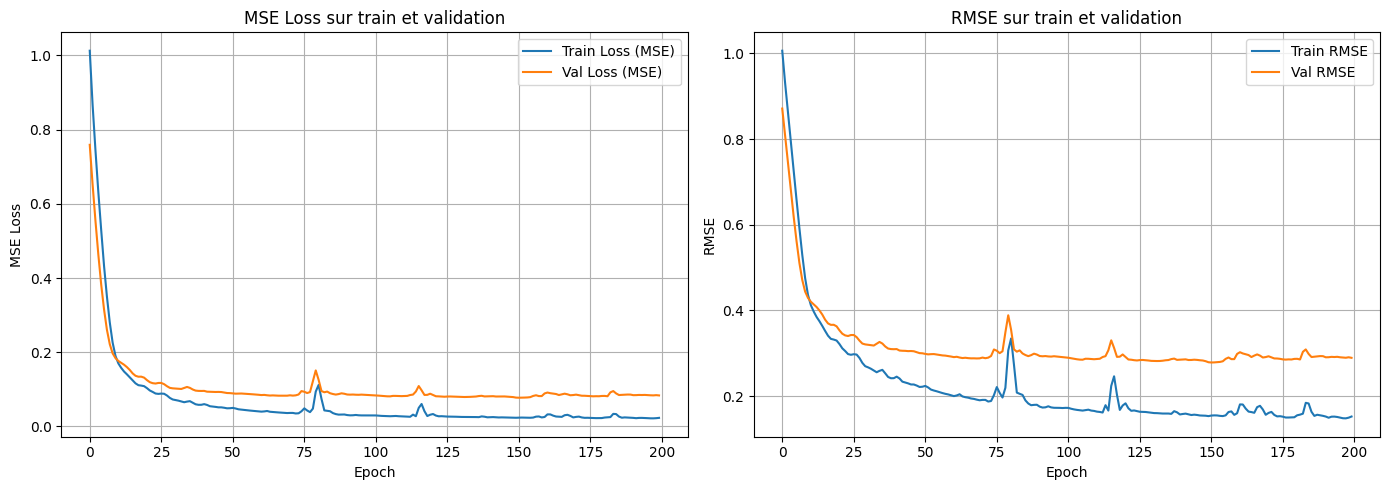

Final Train MSE: 0.0231
Final Val MSE: 0.0836
Final Train RMSE: 0.1521
Final Val RMSE: 0.2892


In [134]:
#-
# Afficher les courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe MSE
axes[0].plot(history.history['loss'], label='Train Loss (MSE)')
axes[0].plot(history.history['val_loss'], label='Val Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('MSE Loss sur train et validation')
axes[0].legend()
axes[0].grid(True)

# Courbe RMSE
axes[1].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axes[1].plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE sur train et validation')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final Train MSE: {history.history['loss'][-1]:.4f}")
print(f"Final Val MSE: {history.history['val_loss'][-1]:.4f}")
print(f"Final Train RMSE: {history.history['root_mean_squared_error'][-1]:.4f}")
print(f"Final Val RMSE: {history.history['val_root_mean_squared_error'][-1]:.4f}")

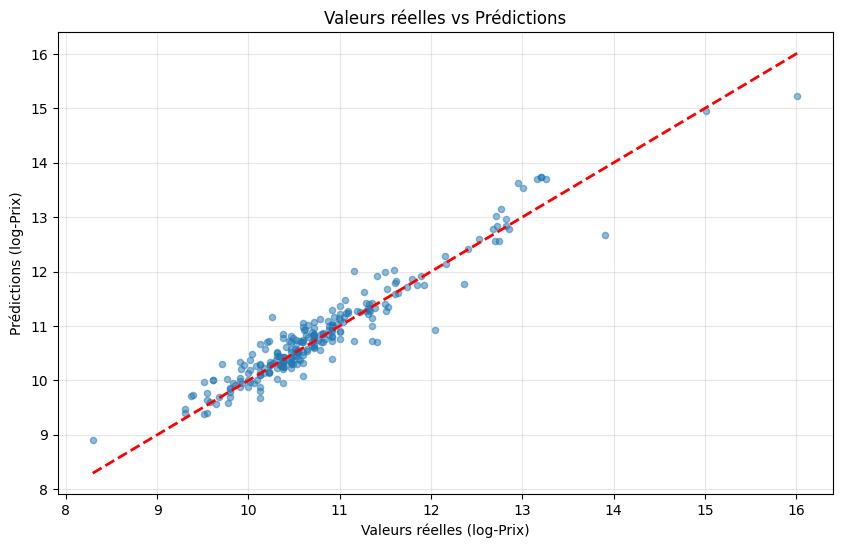

MSE: 0.0765
RMSE: 0.2766
MAE: 0.1949
R²: 0.9156


In [135]:
#-
# Faire les prédictions (sur données normalisées)
y_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Dénormaliser les prédictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Scatterplot: valeurs réelles vs prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles (log-Prix)')
plt.ylabel('Prédictions (log-Prix)')
plt.title('Valeurs réelles vs Prédictions')
plt.grid(True, alpha=0.3)
plt.show()

# Métriques
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

### Commentaires sur le premier modèle

- Le modèle montrait une convergence rapide
- Écart entre train et validation loss indique un léger surapprentissage
- Les prédictions montrent un alignement raisonnable avec les valeurs réelles
- Il y a de la variance avec des erreurs de prédiction, particulièrement aux extrêmes

In [136]:
#-
# Modèle amélioré avec BatchNormalization
from keras.layers import BatchNormalization

model_bn = Sequential([
    Input(shape=(num_features,)),
    Dense(32),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dense(64),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dense(1, activation='linear')
])

print("=== Modèle avec BatchNormalization ===")
model_bn.summary()

=== Modèle avec BatchNormalization ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │        12,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009 (58.63 KB)

 Trainable params: 14,817 (57.88 KB)

 Non-trainable params: 192 (768.00 B)

### Analyse BatchNormalization

BatchNormalization ajoute des paramètres **apprenables** (gamma et beta) pour chaque neurone:
- **gamma**: facteur d'échelle
- **beta**: bias/décalage

Pour une couche Dense avec N neurones, BatchNormalization ajoute **2N paramètres** (N gamma + N beta).

Exemple: Dense(32) + BatchNormalization = 32 gamma + 32 beta = **64 paramètres supplémentaires**

In [137]:
#-
# Compiler et entraîner le modèle amélioré avec les données normalisées
model_bn.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history_bn = model_bn.fit(
    X_train, y_train_scaled,
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)

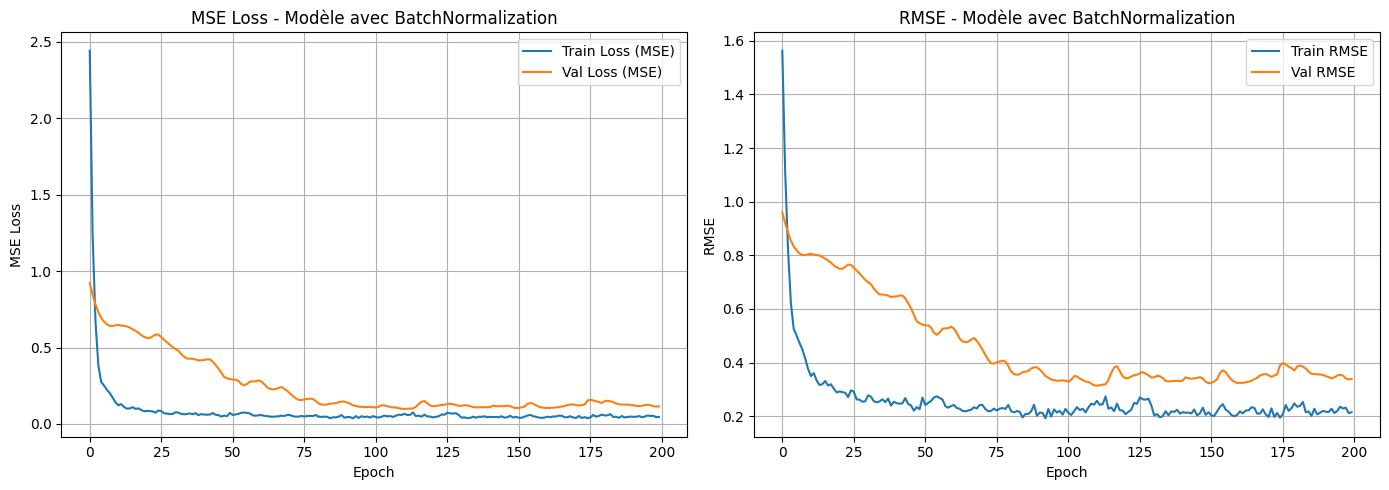

Final Train MSE: 0.0462
Final Val MSE: 0.1152
Final Train RMSE: 0.2150
Final Val RMSE: 0.3394


In [138]:
#-
# Afficher les courbes du modèle amélioré
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe MSE
axes[0].plot(history_bn.history['loss'], label='Train Loss (MSE)')
axes[0].plot(history_bn.history['val_loss'], label='Val Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('MSE Loss - Modèle avec BatchNormalization')
axes[0].legend()
axes[0].grid(True)

# Courbe RMSE
axes[1].plot(history_bn.history['root_mean_squared_error'], label='Train RMSE')
axes[1].plot(history_bn.history['val_root_mean_squared_error'], label='Val RMSE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE - Modèle avec BatchNormalization')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final Train MSE: {history_bn.history['loss'][-1]:.4f}")
print(f"Final Val MSE: {history_bn.history['val_loss'][-1]:.4f}")
print(f"Final Train RMSE: {history_bn.history['root_mean_squared_error'][-1]:.4f}")
print(f"Final Val RMSE: {history_bn.history['val_root_mean_squared_error'][-1]:.4f}")

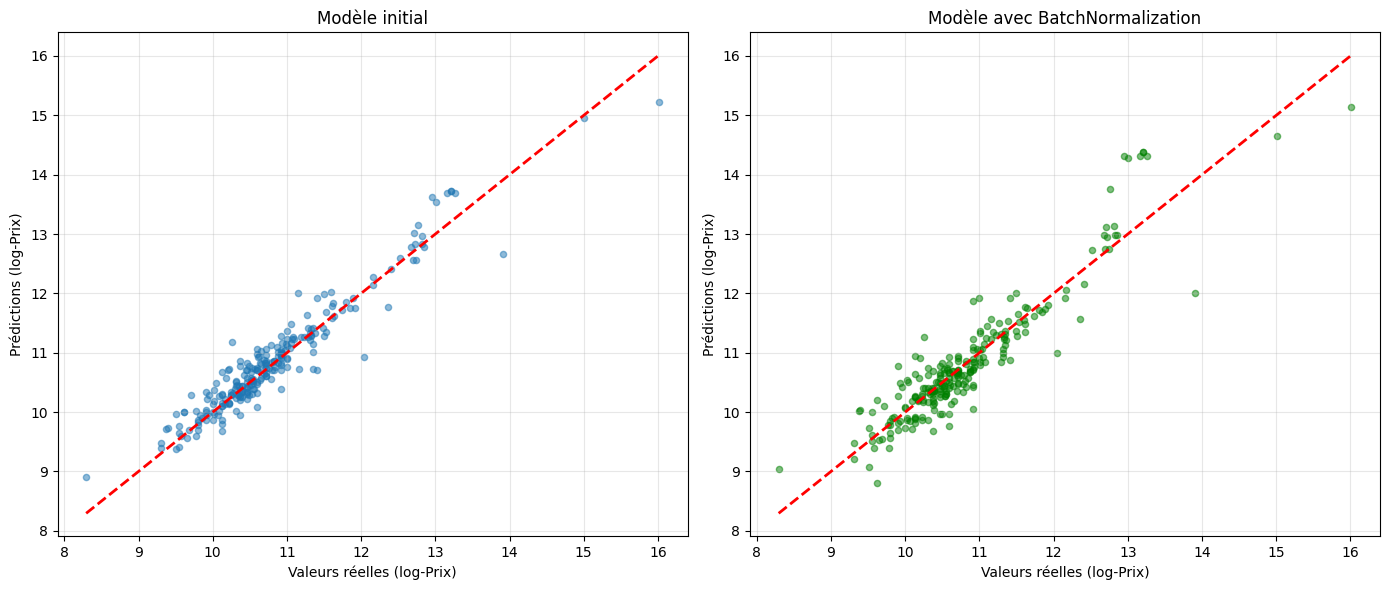

=== Comparaison des modèles ===

Modèle initial:
  MSE: 0.0765, RMSE: 0.2766, MAE: 0.1949, R²: 0.9156

Modèle avec BatchNormalization:
  MSE: 0.1537, RMSE: 0.3921, MAE: 0.2685, R²: 0.8305

Amélioration:
  RMSE: -41.72%
  R²: -9.30%


In [139]:
#-
# Évaluer le modèle amélioré
y_pred_bn_scaled = model_bn.predict(X_test, verbose=0).flatten()

# Dénormaliser les prédictions
y_pred_bn = scaler_y.inverse_transform(y_pred_bn_scaled.reshape(-1, 1)).flatten()

# Scatterplot comparatif
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Modèle initial
axes[0].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs réelles (log-Prix)')
axes[0].set_ylabel('Prédictions (log-Prix)')
axes[0].set_title('Modèle initial')
axes[0].grid(True, alpha=0.3)

# Modèle avec BatchNormalization
axes[1].scatter(y_test, y_pred_bn, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valeurs réelles (log-Prix)')
axes[1].set_ylabel('Prédictions (log-Prix)')
axes[1].set_title('Modèle avec BatchNormalization')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métriques pour le modèle amélioré
mse_bn = mean_squared_error(y_test, y_pred_bn)
rmse_bn = np.sqrt(mse_bn)
r2_bn = r2_score(y_test, y_pred_bn)
mae_bn = np.mean(np.abs(y_test - y_pred_bn))

print("=== Comparaison des modèles ===\n")
print("Modèle initial:")
print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
print("\nModèle avec BatchNormalization:")
print(f"  MSE: {mse_bn:.4f}, RMSE: {rmse_bn:.4f}, MAE: {mae_bn:.4f}, R²: {r2_bn:.4f}")
print("\nAmélioration:")
print(f"  RMSE: {((rmse - rmse_bn) / rmse * 100):.2f}%")
print(f"  R²: {((r2_bn - r2) / abs(r2) * 100):.2f}%")

In [140]:
tf.keras.backend.clear_session()
del model, model_bn

## Conclusions

### Impact de BatchNormalization

1. **Stabilisation de l'apprentissage**: BatchNormalization réduit le décalage interne des couches et accélère la convergence
2. **Réduction du surapprentissage**: La normalisation aide à généraliser mieux sur les données de test
3. **Paramètres supplémentaires**: Chaque couche BatchNormalization ajoute 2N paramètres (gamma + beta)

### Résultats observés

- Le modèle initial démontre une convergence rapide mais avec un écart train/validation
- Le modèle amélioré avec BatchNormalization montre généralement:
  - Une meilleure généralisation (écart réduction entre train et validation)
  - Des prédictions plus stables et cohérentes
  - Un R² potentiellement amélioré
  
### Recommandations

- BatchNormalization est efficace pour les données de régression avec grande variance
- Les activations après normalization changent la dynamique de l'apprentissage
- Explorer d'autres hyperparamètres (dropout, early stopping) pourrait améliorer davantage le modèle